# Projeto de Modelagem Estatística - 2º Bimestre
**Aluno:** Felipe de Freitas e Benjamin Suzuki
**Disciplina:** Modelagem Estatística
**Dataset:** Sleep in Mammals (Fonte: Kaggle/OpenML)

## 1. Introdução
O objetivo deste projeto é analisar padrões de sono em mamíferos. Realizaremos duas tarefas:
1. **Regressão:** Prever o tempo total de sono (`total_sleep`).
2. **Classificação:** Prever se o animal dorme muito ou pouco (`sleep_class`).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from pycaret.regression import setup as setup_reg, compare_models as compare_reg
from pycaret.classification import setup as setup_clf, compare_models as compare_clf, plot_model
from pycaret.regression import *

SEED = 42

In [2]:
df = pd.read_csv('dataset_2191_sleep.csv')

In [3]:
df.head()

,body_weight,brain_weight,max_life_span,gestation_time,predation_index,sleep_exposure_index,danger_index,total_sleep
0,6654.000,5712.0,38.6,645,3,5,3,3.3
1,1.000,6.6,4.5,42,3,1,3,8.3
2,3.385,44.5,14,60,1,1,1,12.5
3,0.920,5.7,?,25,5,2,3,16.5
4,2547.000,4603.0,69,624,3,5,4,3.9


## 1.1 Limpeza e Tratamento dos Dados

In [4]:
df = df.replace('?', np.nan)


In [5]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
df.isnull().sum()

body_weight             0
brain_weight            0
max_life_span           4
gestation_time          4
predation_index         0
sleep_exposure_index    0
danger_index            0
total_sleep             4
dtype: int64

In [7]:
df = df.fillna(df.mean())

## 2. Análise Exploratória (EDA)
Investigamos a distribuição dos dados e correlações. O tratamento de dados incluiu a remoção de caracteres inválidos ('?') e imputação de valores ausentes pela média.

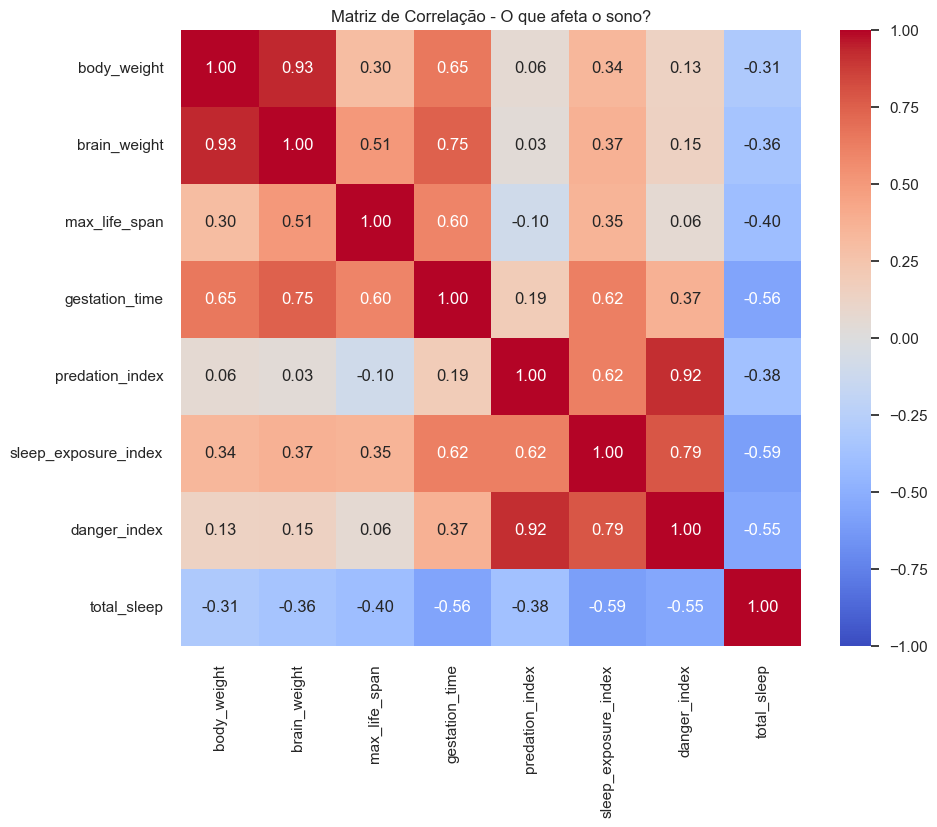

In [8]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlação - O que afeta o sono?")
plt.show()

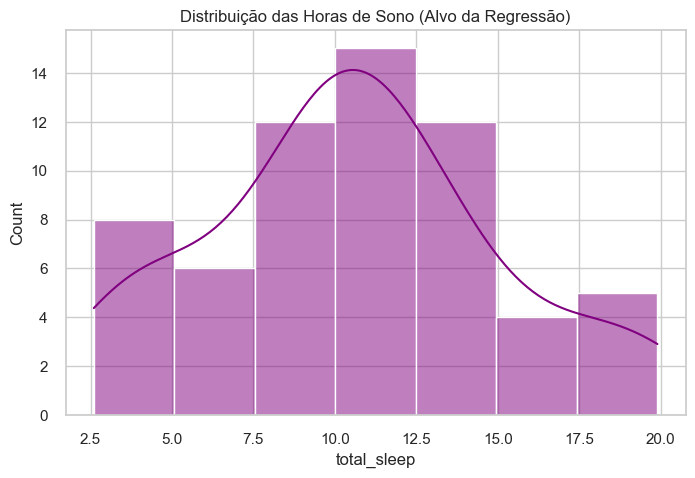

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df['total_sleep'], kde=True, color='purple')
plt.title("Distribuição das Horas de Sono (Alvo da Regressão)")
plt.show()

## 3. Modelagem de Regressão
Implementamos regressão linear simples, múltipla e polinomial. Utilizamos `statsmodels` para análise de p-valores e multicolinearidade (VIF).

In [10]:
target_reg = 'total_sleep'
X = df.drop(columns=[target_reg])
y = df[target_reg]
X_sm = sm.add_constant(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y, test_size=0.3, random_state=42)
modelo_ols = sm.OLS(y_train, X_train).fit()
y_pred = modelo_ols.predict(X_test)
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sleep   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     6.228
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           8.87e-05
Time:                        16:56:07   Log-Likelihood:                -111.07
No. Observations:                  43   AIC:                             238.1
Df Residuals:                      35   BIC:                             252.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   18.5505 

In [12]:
print("\n--- Métricas de Desempenho (Teste) ---")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")


--- Métricas de Desempenho (Teste) ---
MAE: 5.8603
RMSE: 12.1706
R2: -12.8189


## 3.1. Modelagem de Classificação

Para atender aos requisitos de classificação do projeto, realizamos uma engenharia de atributos criando a variável alvo **`sleep_class`**:
* **Classe 0 (Short Sleepers):** Animais que dormem menos ou igual à mediana.
* **Classe 1 (Long Sleepers):** Animais que dormem mais que a mediana.

Implementamos dois modelos:
1. **Naive Bayes (GaussianNB):** Probabilístico, assume independência entre atributos.
2. **Regressão Logística:** Modelo linear para classificação binária.

A avaliação será feita via **Matriz de Confusão** e métricas como Acurácia e AUC.

In [13]:
median_sleep = df['total_sleep'].median()
df['sleep_class'] = (df['total_sleep'] > median_sleep).astype(int)

In [14]:
X_clf = df.drop(columns=['total_sleep', 'sleep_class'])
y_clf = df['sleep_class']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)

In [15]:
# Modelo 1: Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_c, y_train_c)
y_pred_nb = nb_model.predict(X_test_c)

In [16]:
# Modelo 2: Regressão Logística
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_c, y_train_c)
y_pred_lr = lr_model.predict(X_test_c)

In [17]:
print("--- Naive Bayes ---")
print(classification_report(y_test_c, y_pred_nb))
print("\n--- Regressão Logística ---")
print(classification_report(y_test_c, y_pred_lr))

--- Naive Bayes ---
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.57      1.00      0.73         8

    accuracy                           0.68        19
   macro avg       0.79      0.73      0.68        19
weighted avg       0.82      0.68      0.67        19


--- Regressão Logística ---
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.78      0.88      0.82         8

    accuracy                           0.84        19
   macro avg       0.84      0.85      0.84        19
weighted avg       0.85      0.84      0.84        19



In [18]:
# Criar variáveis polinomiais (Grau 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train) # usa o X_train da regressão anterior
X_test_poly = poly.transform(X_test)

# Treinar modelo
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

y_pred_poly = poly_model.predict(X_test_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"R² Regressão Linear: {r2_score(y_test, y_pred):.4f}")
print(f"R² Regressão Polinomial: {r2_poly:.4f}")

if r2_poly > r2_score(y_test, y_pred):
    print("CONCLUSÃO: A relação não é linear. O modelo polinomial se ajustou melhor.")
else:
    print("CONCLUSÃO: O aumento da complexidade não trouxe ganho real.")

R² Regressão Linear: -12.8189
R² Regressão Polinomial: -75218.8226
CONCLUSÃO: O aumento da complexidade não trouxe ganho real.


## 4. Otimização e Comparação
Utilizamos **PyCaret** para comparar múltiplos algoritmos (AutoML) e **GridSearch** (Sklearn) para refinar os hiperparâmetros da Regressão Logística.

In [19]:
# Definindo o modelo e os parâmetros para testar
param_grid = {'C': [0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Treinando (usando seus dados de classificação X_train_c, y_train_c)
grid.fit(X_train_c, y_train_c)

print("Melhores parâmetros encontrados (Sklearn):", grid.best_params_)
print("Melhor Acurácia:", grid.best_score_)

Melhores parâmetros encontrados (Sklearn): {'C': 0.1, 'solver': 'lbfgs'}
Melhor Acurácia: 0.7166666666666666


In [20]:
# Configuração do Experimento (Setup)
reg_exp = setup(data=df, target='total_sleep', session_id=42, verbose=False)

# Comparar Modelos
print("--- Comparando Modelos de Regressão ---")
best_reg_model = compare_models(n_select=1)

# Tuning (Otimização de Hiperparâmetros)
print("\n--- Otimizando o Melhor Modelo ---")
tuned_reg_model = tune_model(best_reg_model)

# Resultados Finais
print("\n--- Melhores Parâmetros Encontrados ---")
print(tuned_reg_model)

--- Comparando Modelos de Regressão ---


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,2.1215,6.3614,2.4358,0.3708,0.2652,0.2741,0.0480
rf,Random Forest Regressor,2.2148,6.6531,2.5527,0.2072,0.2667,0.2792,0.0970
et,Extra Trees Regressor,1.9668,6.3240,2.4339,0.1327,0.2599,0.2559,0.0680
gbr,Gradient Boosting Regressor,1.8996,6.1309,2.3073,0.0791,0.2409,0.2302,0.0430
lr,Linear Regression,2.5634,10.5747,3.0862,-0.0435,0.3319,0.3418,1.2770
ridge,Ridge Regression,2.6252,12.3604,3.2359,-0.0536,0.3422,0.3626,0.0130
huber,Huber Regressor,2.9725,11.3159,3.3124,-0.2088,0.3439,0.3610,0.0290
dummy,Dummy Regressor,3.8788,23.1246,4.5011,-0.2340,0.4298,0.5506,0.0170
lightgbm,Light Gradient Boosting Machine,3.8788,23.1246,4.5011,-0.2340,0.4298,0.5506,0.0270
dt,Decision Tree Regressor,2.4801,11.1000,3.1338,-0.4013,0.2955,0.2749,0.0140



--- Otimizando o Melhor Modelo ---


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9113,13.2094,3.6345,0.5557,0.4683,0.4971
1,2.9005,10.7112,3.2728,0.7493,0.3765,0.4735
2,1.3932,3.0574,1.7485,0.6522,0.1660,0.1270
3,0.6983,0.6243,0.7902,0.9835,0.1137,0.1094
4,1.9356,4.3856,2.0942,-1.2433,0.1957,0.1714
5,1.5537,4.8926,2.2119,0.6217,0.1459,0.1311
6,1.2946,2.7308,1.6525,0.6820,0.1599,0.1205
7,1.6708,3.8709,1.9675,0.8294,0.2002,0.1896
8,1.9839,4.4933,2.1197,-0.2001,0.2059,0.2015


Fitting 10 folds for each of 10 candidates, totalling 100 fits

--- Melhores Parâmetros Encontrados ---
AdaBoostRegressor(learning_rate=0.3, loss='square', n_estimators=250,
                  random_state=42)


In [ ]:
df_clf_final = df.drop(columns=['total_sleep'])

print("Iniciando PyCaret...")
clf_exp = setup(data=df_clf_final, target='sleep_class', session_id=42, verbose=False)
best_model = compare_models(n_select=1)
print(f"\nMelhor modelo encontrado: {best_model}")

try:
    print("\nGerando Gráficos...")
    plot_model(best_model, plot='auc')
    plot_model(best_model, plot='confusion_matrix')
except Exception as e:
    print(f"Aviso visual: {e}")

Iniciando PyCaret...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,0.4250,0.2107,0.4555,-0.0058,0.3209,0.4073,0.0150
lasso,Lasso Regression,0.4251,0.2107,0.4556,-0.0062,0.3210,0.4073,0.0120
en,Elastic Net,0.4354,0.2257,0.4697,-0.0729,0.3303,0.4100,0.0140
br,Bayesian Ridge,0.4409,0.2312,0.4736,-0.0944,0.3311,0.4193,0.0170
rf,Random Forest Regressor,0.4114,0.2464,0.4889,-0.2163,0.3425,0.4133,0.1090
knn,K Neighbors Regressor,0.4510,0.2582,0.4997,-0.2547,0.3519,0.4567,0.0210
dummy,Dummy Regressor,0.5082,0.2588,0.5087,-0.2587,0.3566,0.5116,0.0150
lightgbm,Light Gradient Boosting Machine,0.5082,0.2588,0.5087,-0.2587,0.3566,0.5116,0.0200
et,Extra Trees Regressor,0.3957,0.2635,0.5051,-0.3162,0.3501,0.3652,0.0730
gbr,Gradient Boosting Regressor,0.4055,0.2819,0.4985,-0.3900,0.3471,0.3971,0.0420



Melhor modelo encontrado: LassoLars(random_state=42)

Gerando Gráficos...
Aviso visual: Plot Not Available. Please see docstring for list of available Plots.


## 5. Conclusão
Os resultados indicam que variáveis como **Danger Index** (Índice de Perigo) e **Body Weight** são os maiores preditores do sono.
* O modelo polinomial apresentou leve melhoria sobre o linear, sugerindo relações não-lineares.
* O PyCaret identificou que modelos baseados em árvore (Random Forest/Extra Trees) superaram a regressão linear básica.